# Classification Problem

In this notebook, we will try to make predictions to tree type classification problem from Roosevelt National Forest.

---

## Preliminary

__Import Libraries__

In [0]:
# essentials 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing 
from sklearn.preprocessing import StandardScaler

# model selection 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# pipeline
from sklearn.pipeline import Pipeline

# ML algorithms 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

# supress warnings
import warnings
warnings.filterwarnings('ignore')

Load the dataset:

In [0]:
dataset = pd.read_csv('train.csv')

Look at the first five of our dataset.

In [0]:
dataset.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


How many data points and columns are there?

In [0]:
dataset.shape

(15120, 56)

So... This dataset contains 15120 data points and 56 features. Let's see what features are there

In [0]:
dataset.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

Note that we have 4 columns of Wilderness Area already encoded and 40 columns of Soil Type also already encoded. 

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

We have clean data without null values. Now let's convert the dataset to Numpy array and seperate it to feature matrix and target vector (Cover_Type).

In [0]:
X = dataset.iloc[:, 1:-1].values # exclude the columns id and target vector
y = dataset.iloc[:, -1].values # the target vector

In [68]:
print("Feature matrix shape: {}".format(X.shape))
print("Target vector shape:{}".format(y.shape))

Feature matrix shape: (15120, 54)
Target vector shape:(15120,)


Let's move to the next phase which is predictive modeling.

----

## Predictive Modeling

In predictive modeling, we will use several machine learning algorithms to make the predictions. At each ML algorithm, we will evalute the model performance with accuracy metric using cross_val_score and look for the best hyperparameters using GridSearchCV or RandomizedSearchCV class.

### KNeighborsClassifier

This ML algorithm is one of the simplest model to use and commonly used at early stage of predictive modeling, before step up to more advanced ML algorithm. Note  that this model need scaled data to get better performance, but for learning purpose, we dont scale the data first and use the default hyperparameters.

In [0]:
knn_default_no_scaling_score = cross_val_score(KNeighborsClassifier(), X, y, cv=5, scoring='accuracy')
print("KNeighborsClassifier cross val score (default & no scaling): {}".format(knn_default_no_scaling_score))
print("The mean score: {:.3f}".format(knn_default_no_scaling_score.mean()))

KNeighborsClassifier cross val score (default & no scaling): [0.69477513 0.66104497 0.65046296 0.65674603 0.79199735]
The mean score: 0.691


Without scaling the data and using default hyperparameters give us a quite good performance (above 50% is quite good for balanced dataset). Now, we scale the data using StandardScaler, to see the performance

In [0]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [0]:
knn_default_score = cross_val_score(pipe_knn, X, y, cv=5, scoring='accuracy')
print("KNeighborsClassifier cross val score (default & scaled): {}".format(knn_default_score))
print("The mean score: {:.3f}".format(knn_default_score.mean()))

KNeighborsClassifier cross val score (default & scaled): [0.6630291  0.64451058 0.64153439 0.70701058 0.76256614]
The mean score: 0.684


It goes down a bit (~0.01), probably because we try to prevent data leakage. Let's see what happens if we tweak the hyperparameters. In here we only use weights and n_neighbors.

In [0]:
param_grid = {
    'knn__weights' : ['distance', 'uniform'],
    'knn__n_neighbors' : list(range(2, 21)) # we test n_neighbors parameter from 2 to 20
}

grid_knn = RandomizedSearchCV(pipe_knn, param_distributions=param_grid, cv=5, scoring='accuracy', n_iter=10, n_jobs=-1).fit(X, y)

In [0]:
grid_knn.best_score_

0.7066137566137566

In [0]:
grid_knn.best_params_

{'knn__n_neighbors': 5, 'knn__weights': 'distance'}

In [0]:
knn_results = pd.DataFrame(grid_knn.cv_results_)[['param_knn__weights', 'param_knn__n_neighbors', 'mean_test_score']].groupby(['param_knn__weights', 'param_knn__n_neighbors']).mean()
knn_results

mean_test_score
param_knn__weights param_knn__n_neighbors                 
distance           5                              0.706614
                   7                              0.700595
                   10                             0.692394
                   14                             0.681019
                   18                             0.673611
                   20                             0.668783
uniform            2                              0.689153
                   4                              0.690146
                   11                             0.660251
                   12                             0.656944

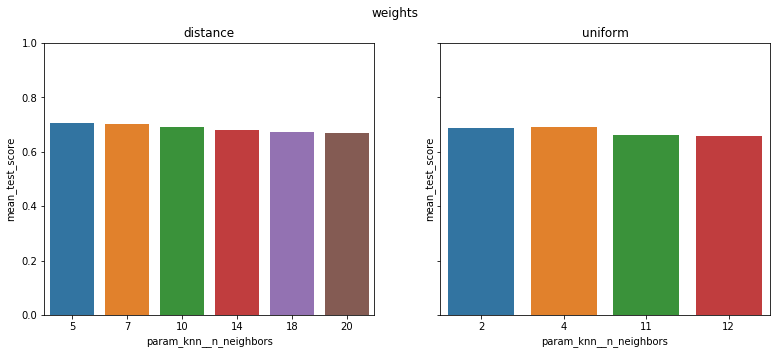

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

sns.barplot(data=knn_results.reset_index()[knn_results.reset_index()['param_knn__weights'] == 'distance'], x='param_knn__n_neighbors', y='mean_test_score', ax=ax[0])
sns.barplot(data=knn_results.reset_index()[knn_results.reset_index()['param_knn__weights'] == 'uniform'], x='param_knn__n_neighbors', y='mean_test_score', ax=ax[1])
ax[0].set(title='distance', ylim=(0, 1))
ax[1].set(title='uniform', ylim=(0, 1))
fig.suptitle('weights');

In [0]:
knn_optimized_score = cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='accuracy')
print("KNeighborsClassifier cross val score (optimized): {}".format(knn_optimized_score))
print("The mean score: {:.3f}".format(knn_optimized_score.mean()))

KNeighborsClassifier cross val score (optimized): [0.68882275 0.66005291 0.66865079 0.73313492 0.78240741]
The mean score: 0.707


The best score is 0.71, which use hyperparameter n_neighbors=3 and weights=distance. Note that since we are using RandomizedSearchCV, not all hyperparameters listed in param_grid are used. So it is probable if we missed the real hyperparameters.

### Gaussian NB

Another simple ML algorithms to use without complex hyperparameter.

In [0]:
gaussian_score = cross_val_score(GaussianNB(), X, y, cv=5, scoring='accuracy')
print("GaussianNB cross val score: {}".format(gaussian_score))
print("The mean score: {:.3f}".format(gaussian_score.mean()))

GaussianNB cross val score: [0.56084656 0.51719577 0.55886243 0.61011905 0.59556878]
The mean score: 0.569


Certainly not better than using KNeighborsClassifier, but it is worth to understand. Since for common text classification and if we are working with sparsed data, we oftenly use GaussianNB, MultinomialNB, and BernoulliNB.

### LogisticRegression

Now, we will use LogisticRegression, let's start with default hyperparameters.

In [0]:
logreg_default_score = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='accuracy')
print("LogisticRegression cross val score (default): {}".format(logreg_default_score))
print("The mean score: {:.3f}".format(logreg_default_score.mean()))

LogisticRegression cross val score (default): [0.54332011 0.55919312 0.63425926 0.63558201 0.66832011]
The mean score: 0.608


Now, we use RandomizedSearchCV to find the optimized model, we use two hyperparameters: penalty and C.

In [0]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_logreg = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, cv=3, scoring='accuracy', n_iter=10, n_jobs=-1).fit(X, y)

In [0]:
grid_logreg.best_score_

0.6244047619047619

In [0]:
grid_logreg.best_params_

{'C': 10, 'penalty': 'l1'}

In [0]:
logreg_results = pd.DataFrame(grid_logreg.cv_results_)[['param_penalty', 'param_C', 'mean_test_score']].groupby(['param_penalty', 'param_C']).mean()
logreg_results

mean_test_score
param_penalty param_C                  
l1            0.0001           0.438889
              0.0010           0.530886
              1.0000           0.623677
              10.0000          0.624405
              100.0000         0.623545
l2            0.0001           0.539286
              0.0010           0.571495
              0.1000           0.617460
              1.0000           0.613029
              10.0000          0.615939

In [0]:
logreg_optimized_score = cross_val_score(grid_logreg.best_estimator_, X, y, cv=5, scoring='accuracy')
print("LogisticRegression cross val score (optimized): {}".format(logreg_optimized_score))
print("The mean score: {:.3f}".format(logreg_optimized_score.mean()))

LogisticRegression cross val score (optimized): [0.56448413 0.56183862 0.64384921 0.65277778 0.68154762]
The mean score: 0.621


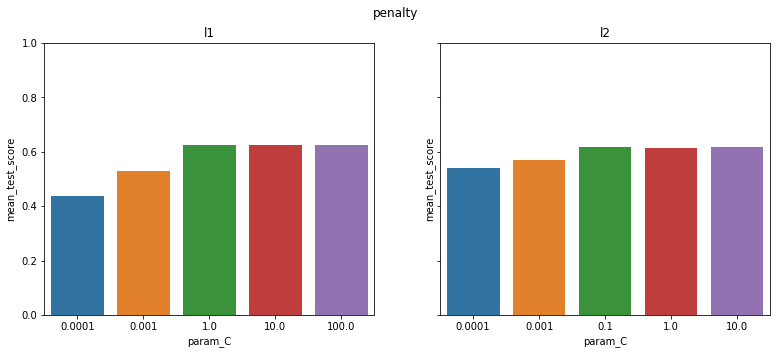

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

sns.barplot(data=logreg_results.reset_index()[logreg_results.reset_index()['param_penalty'] == 'l1'], x='param_C', y='mean_test_score', ax=ax[0])
sns.barplot(data=logreg_results.reset_index()[logreg_results.reset_index()['param_penalty'] == 'l2'], x='param_C', y='mean_test_score', ax=ax[1])
ax[0].set(title='l1', ylim=(0, 1))
ax[1].set(title='l2', ylim=(0, 1))
fig.suptitle('penalty');

The best score we get is 0.62, not better than using KNeighborsClassfier.

### SGDClassifier

In here, we use SGDClassfier which powered by randomness, and faster than using LogisticRegression, since it iterates the data points one at a time and update the weights using gradient descent method. Below we don't scale the data first, then we scale it.

In [0]:
sgd_default_no_scaling_score = cross_val_score(SGDClassifier(), X, y, cv=5, scoring='accuracy')
print("SGDClassifier cross val score (default & no scaling): {}".format(sgd_default_no_scaling_score))
print("The mean score: {:.3f}".format(sgd_default_no_scaling_score.mean()))

SGDClassifier cross val score (default & no scaling): [0.3042328  0.19080688 0.32671958 0.20634921 0.43518519]
The mean score: 0.293


The score is much worse than previous model's scores, certainly need some improvements. Now, we scale it with Pipeline

In [0]:
pipe_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier())
])

In [0]:
sgd_default_score = cross_val_score(pipe_sgd, X, y, cv=5, scoring='accuracy')
print("SGDClassifier cross val score (default & scaled): {}".format(sgd_default_score))
print("The mean score: {:.3f}".format(sgd_default_score.mean()))

SGDClassifier cross val score (default & scaled): [0.53406085 0.51653439 0.6140873  0.61871693 0.62830688]
The mean score: 0.582


Now, it looks better from before scaling. Then we find the optimized model by using hyperparameters: penalty, alpha and l1 ratio.

In [0]:
param_grid = {
    'sgd__penalty' : ['elasticnet'], # use elasticnet only
    'sgd__alpha' : [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'sgd__l1_ratio' : [0, 0.25, 0.5, 0.75, 1]
}

grid_sgd = RandomizedSearchCV(pipe_sgd, param_distributions=param_grid, cv=3, scoring='accuracy', n_iter=10, n_jobs=-1).fit(X, y)

In [0]:
grid_sgd.best_score_

0.600462962962963

In [0]:
grid_sgd.best_params_

{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0, 'sgd__penalty': 'elasticnet'}

In [0]:
sgd_results = pd.DataFrame(grid_sgd.cv_results_)[['param_sgd__alpha', 'param_sgd__l1_ratio', 'mean_test_score']].groupby(['param_sgd__l1_ratio', 'param_sgd__alpha']).mean()
sgd_results

mean_test_score
param_sgd__l1_ratio param_sgd__alpha                 
0.00                0.010                    0.600463
                    10.000                   0.212963
                    100.000                  0.244312
0.25                0.010                    0.591270
                    1.000                    0.142857
0.50                0.001                    0.590542
                    0.010                    0.578505
0.75                1.000                    0.142857
                    10.000                   0.142857
1.00                0.001                    0.596825

In [0]:
sgd_optimized_score = cross_val_score(grid_sgd.best_estimator_, X, y, cv=5, scoring='accuracy')
print("SGDClassifier cross val score (optimized): {}".format(sgd_optimized_score))
print("The mean score: {:.3f}".format(sgd_optimized_score.mean()))

SGDClassifier cross val score (optimized): [0.50859788 0.54298942 0.61044974 0.64550265 0.64384921]
The mean score: 0.590


We get the best score using SGDClassifier ~0.57. 

### LinearSVC

In this subsection, we use SVC with kernel trick linear (not the same SVC with kernel trick linear). Note: we need to scale the data first to get better performance.

In [0]:
linsvc_default_no_scaling_score = cross_val_score(LinearSVC(), X, y, cv=5, scoring='accuracy')
print("LinearSVC cross val score (default & no scaling): {}".format(linsvc_default_no_scaling_score))
print("The mean score: {:.3f}".format(linsvc_default_no_scaling_score.mean()))

LinearSVC cross val score (default & no scaling): [0.35119048 0.43849206 0.34490741 0.37632275 0.24867725]
The mean score: 0.352


With scaling:

In [0]:
pipe_linsvc = Pipeline([
    ('scaler', StandardScaler()),
    ('linsvc', LinearSVC())
])

In [0]:
linsvc_default_score = cross_val_score(pipe_linsvc, X, y, cv=5, scoring='accuracy')
print("LinearSVC cross val score (default & scaled): {}".format(linsvc_default_score))
print("The mean score: {:.3f}".format(linsvc_default_score.mean()))

LinearSVC cross val score (default & scaled): [0.55919312 0.55919312 0.64384921 0.65707672 0.68320106]
The mean score: 0.621


There is a slight improvement. Let's continue it by finding optimized model.

In [0]:
param_grid = {
    'linsvc__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}
grid_linsvc = RandomizedSearchCV(pipe_linsvc, param_distributions=param_grid, cv=3, scoring='accuracy', n_iter=10, n_jobs=-1).fit(X, y)

In [0]:
grid_linsvc.best_score_

0.6216931216931217

In [0]:
grid_linsvc.best_params_

{'linsvc__C': 1}

In [0]:
linsvc_results = pd.DataFrame(grid_linsvc.cv_results_)[['param_linsvc__C', 'mean_test_score']].groupby(['param_linsvc__C']).mean()
linsvc_results

,mean_test_score
param_linsvc__C,
0.0001,0.566138
0.0010,0.587897
0.0100,0.609392
0.1000,0.619246
1.0000,0.621693
10.0000,0.583333
100.0000,0.520701


RandomizedSearch find that the best C parameter is 1, which is the default.

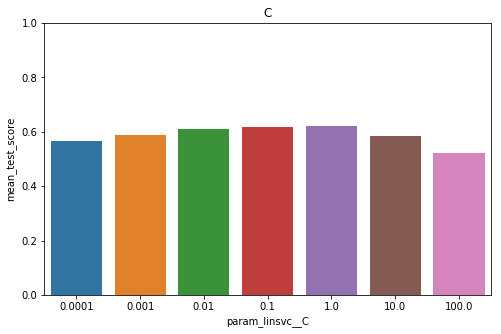

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(data=linsvc_results.reset_index(), x='param_linsvc__C', y='mean_test_score', ax=ax)
ax.set(title='C', ylim=(0, 1));

Since the best hyperparameter we found is the default, we cannot see any imporvement using RandomizedSearchCV. Still, the score is quite good.

---

## Random Forest Classifier

Here, we will use one of the ensemble learning algorithms which is RandomForestClassifier. Let's start by using default model

In [0]:
rf_default = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='accuracy')
print("RandomForestClassifier cross val score (default): {}".format(rf_default))
print("The mean score: {:.3f}".format(rf_default.mean()))

RandomForestClassifier cross val score (default & no scaling): [0.70568783 0.71593915 0.74140212 0.76686508 0.82671958]
The mean score: 0.751


By using decision tree, we don't need to scale the data. So now, let's jump into hyperparameters search

In [0]:
param_grid = {
    'n_estimators' : [400, 450, 500],
    'max_depth' : [1, 2, 3, 4, 5],
    'max_features' : [2, 3, 4, 5, 10, 20, 30]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1).fit(X, y)

In [0]:
grid_rf.best_score_

0.6695767195767196

In [0]:
grid_rf.best_params_

{'max_depth': 5, 'max_features': 20, 'n_estimators': 450}

In [0]:
rf_default = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=3, max_features=25), X, y, cv=5, scoring='accuracy')
print("RandomForestClassifier cross val score (default & no scaling): {}".format(rf_default))
print("The mean score: {:.3f}".format(rf_default.mean()))

RandomForestClassifier cross val score (default & no scaling): [0.52943122 0.58928571 0.62533069 0.65178571 0.65839947]
The mean score: 0.611


### Gradient Boosting Classifier

In [69]:
gbrt_default = cross_val_score(GradientBoostingClassifier(), X, y, cv=5, scoring='accuracy')
print("GradientBoostingClassifier cross val score (default): {}".format(gbrt_default))
print("The mean score: {:.3f}".format(gbrt_default.mean()))

GradientBoostingClassifier cross val score (default): [0.68518519 0.67427249 0.7281746  0.74371693 0.78769841]
The mean score: 0.724


In [0]:
param_grid = {
    'n_estimators' : [400, 450, 500],
    'max_depth' : [1, 2, 3, 4, 5]
}

grid_rf = GridSearchCV(GradientBoostingClassifier(max_features='sqrt'), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1).fit(X, y)

In [0]:
grid_rf.best_score_

0.776984126984127

In [0]:
grid_rf.best_params_

{'max_depth': 5, 'n_estimators': 500}

In [70]:
gbrt = GradientBoostingClassifier(n_estimators=750, max_features='sqrt', max_depth=5)
cross_val_score(gbrt, X, y, cv=5, scoring='accuracy')

array([0.75859788, 0.74140212, 0.76818783, 0.79530423, 0.84358466])

In [72]:
np.mean([0.75859788, 0.74140212, 0.76818783, 0.79530423, 0.84358466])

0.7814153439999999

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [0]:
gbrt = GradientBoostingClassifier(n_estimators=750, max_features='sqrt', max_depth=5).fit(X_train, y_train)

In [75]:
gbrt.score(X_val, y_val)

0.8707010582010583

---

## Chosen Model

In [0]:
gbrt = GradientBoostingClassifier(n_estimators=750, max_features='sqrt', max_depth=5).fit(X, y)

In [78]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy the stackoverflow data set locally.
!kaggle competitions download -c learn-together

  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 80.5MB/s]
 67% 8.00M/11.9M [00:00<00:00, 82.0MB/s]
100% 11.9M/11.9M [00:00<00:00, 76.2MB/s]
  0% 0.00/351k [00:00<?, ?B/s]
100% 351k/351k [00:00<00:00, 103MB/s]


In [0]:
import zipfile
with zipfile.ZipFile("/content/test.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [0]:
test = pd.read_csv('test.csv')

In [81]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_test = test.iloc[:, 1:]

In [0]:
predictions = gbrt.predict(X_test)

In [84]:
predictions.shape

(565892,)

In [87]:
predictions[:5]

array([2, 1, 1, 5, 5])

In [0]:
submit_predictions = pd.DataFrame(predictions, index=test['Id'], columns=['Cover_Type']).reset_index()

In [89]:
submit_predictions.head()

,Id,Cover_Type
0,15121,2
1,15122,1
2,15123,1
3,15124,5
4,15125,5


In [0]:
submit_predictions.to_csv('predictions.csv', index=False)

In [0]:
data = pd.read_csv('predictions.csv')

In [95]:
data.head()

,Id,Cover_Type
0,15121,2
1,15122,1
2,15123,1
3,15124,5
4,15125,5
